In [10]:


x_points = [0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1000]
y_points = [0.5, 0.3, 0.2, 0.14, 0.11, 0.08, 0.05, 0.1, 0.12,0.15, 0.18, 0.21, 0.24, 0.3, 0.38, 0.42, 0.46, 0.55, 0.65, 0.75, 0.85, 1]


In [11]:
x_points_dc = [0, 1, 2, 3, 4, 5,6, 7, 8, 9, 10,100, 1000, 5000]
y_points_dc = [0, 0.01, 0.03, 0.1, 0.15, 0.18, 0.25, 0.31, 0.37, 0.44, 0.5, 1, 1, 1]

In [12]:
from scipy import interpolate
import matplotlib.pyplot as plt

def create_poly(max, x_p, y_p):
    new_x = []
    for x in x_p:
        new_x.append(x*max)

    return interpolate.interp1d(new_x, y_p, kind="cubic")

In [13]:
poly = create_poly(10080, x_points, y_points)

In [14]:
poly_dc = create_poly(10, x_points_dc, y_points_dc)

Text(0.5, 1.0, 'Pressure over Time')

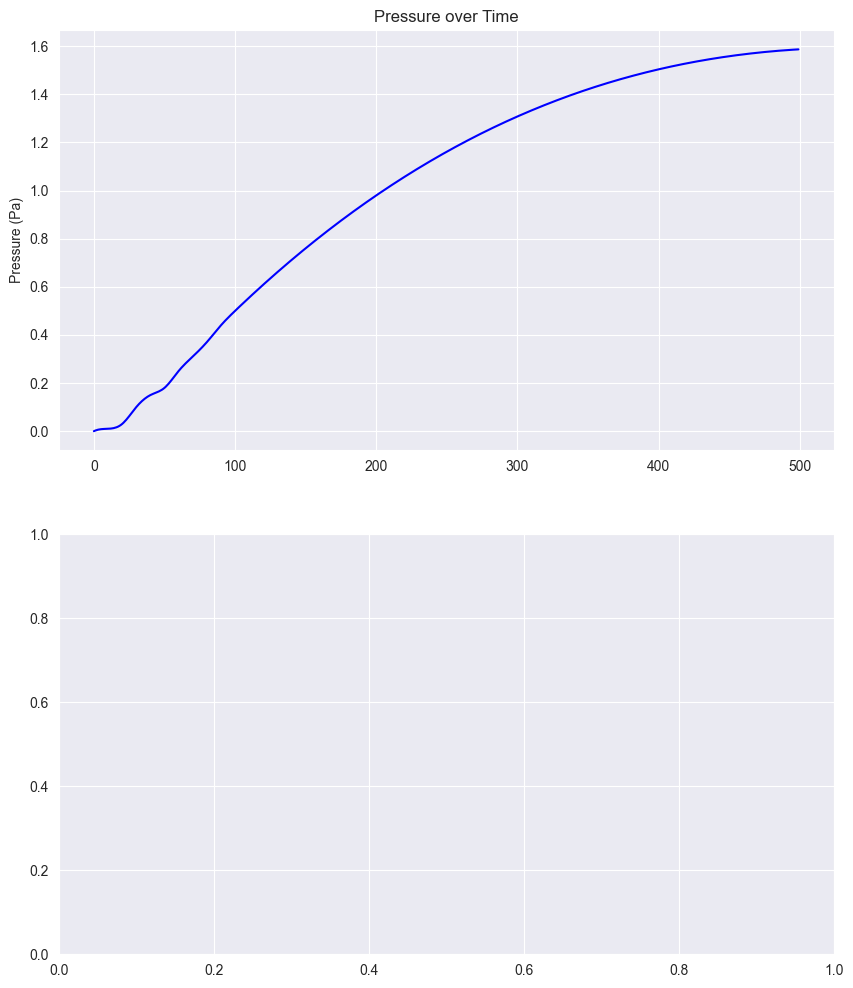

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
x = range(0, 500)
axs[0].plot(x, poly_dc(x), color="blue")
axs[0].set_ylabel("Pressure (Pa)")
axs[0].set_title("Pressure over Time")

In [16]:
def get_health(t, dc):
    res = poly(t) + poly_dc(dc)
    if res<0: res = 0
    if res>1: res = 1
    return res

In [17]:
def generate_error(mean, h):
    return np.random.normal(0, (h)) * 0.07 * mean

In [18]:
def check_fail(val, norm):
    dif = abs(val - norm)
    if dif > norm * 0.15:
        return 1
    return 0

In [19]:
def check_def(val, norm):
    dif = abs(val - norm)
    if norm * 0.15 > dif > norm * 0.1:
        return 1
    return 0

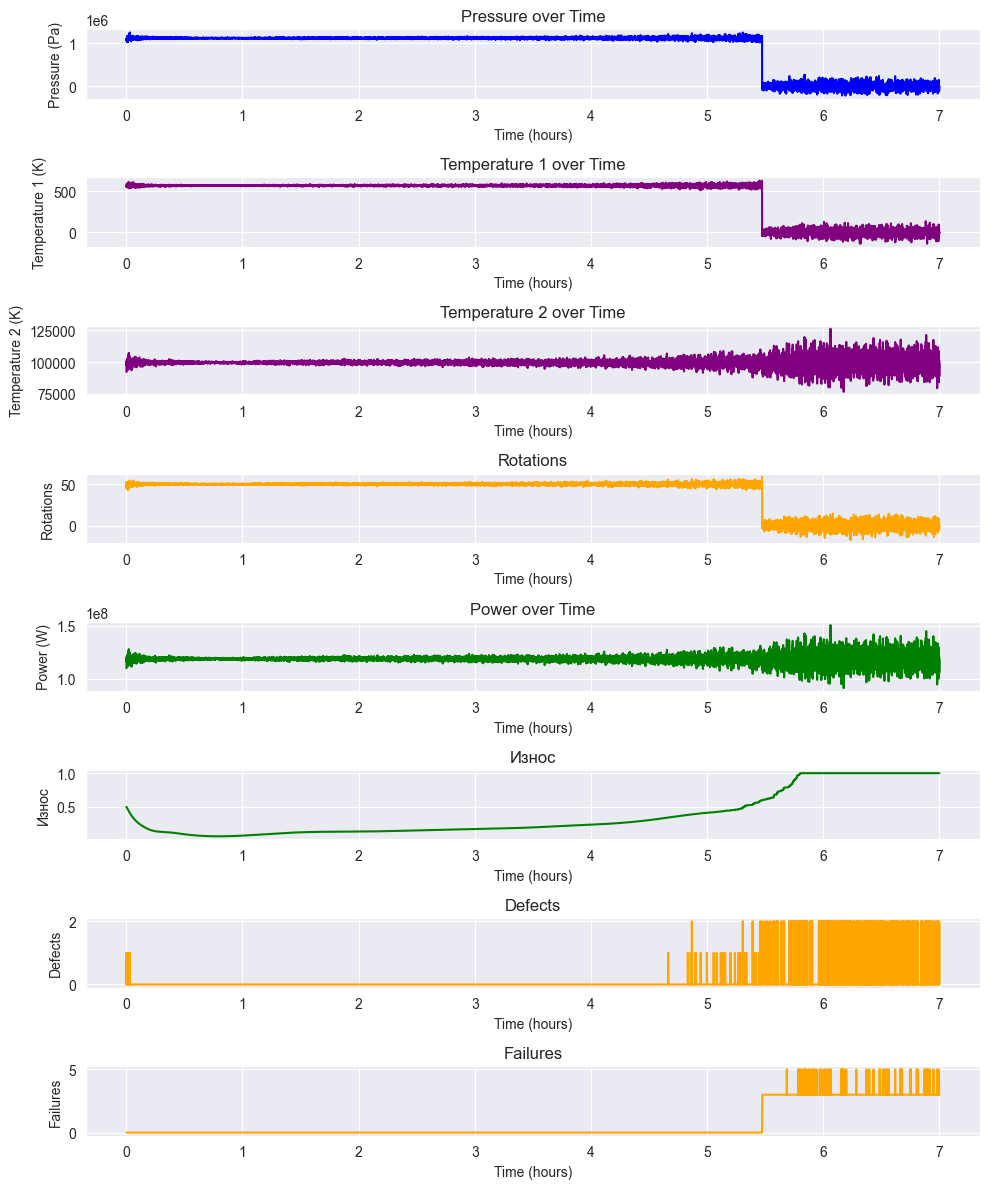

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(2)

h = 0.3 #здоровье
a = -0.3
b = 0.2
max_t = 60 * 24 * 7

# Параметры цикла Брайтона
gamma = 1.4                 # показатель адиабаты воздуха
compression_ratio = 11      # степень сжатия
eta_combustion = 0.36        # КПД сгорания
fuel_energy = 42e6          # Дж/кг, удельная теплота сгорания топлива
fuel_count = 6.58
specific_heat_air = 1005    # Дж/(кг*К), удельная теплоемкость воздуха
mass_flow_rate = 2.395       # кг/с, массовый расход воздуха

# Параметры управления            
time_points = range(1,max_t)  # разбиение на минуты в течение суток

T_start = 288
P_start = 101325

T2_norm = 571
T3_norm = 99566
P_norm = 1114575
R_norm = 50
W_norm = 118859864

# Создаем пустые списки для результатов
temperatures1 = []
temperatures2 = []
pressures = []
powers = []
voltages = []
rotate = []

healths = []
errors = []
fails = []
sum_e = 0

for t in time_points:
    T1 = T_start # K, начальная температура на входе
    P1 = P_start # Па, начальное давление на входе

    # Старение
    h = get_health(t, sum_e)
    # 1. Сжатие (компрессор)
    P2 = P1 * compression_ratio + generate_error(P_norm, h)
    T2 = T1 * compression_ratio ** ((gamma - 1) / gamma)  + generate_error(T2_norm, h)

    # 2. Нагревание при постоянном давлении (камера сгорания)
    T3 = T2 + (eta_combustion * fuel_energy * fuel_count / specific_heat_air) + generate_error(T3_norm, h)
    P3 = P2  # давление остается постоянным

    # 3. Расширение (турбина)
    P4 = P3 / compression_ratio
    T4 = T3 * ((1 / compression_ratio) ** ((gamma - 1) / gamma))
    R = 50 * P2/P_norm  + generate_error(R_norm, h)

    # Рассчитываем текущую мощность
    current_power = mass_flow_rate * specific_heat_air * (T3 - T4)

    # Сохраняем результаты для одного цикла
    temperatures1.append(T2)
    temperatures2.append(T3)
    pressures.append(P2)
    powers.append(current_power)
    healths.append(h)
    rotate.append(R)

    defects = check_def(P2, P_norm) + check_def(T2, T2_norm) + check_def(T3, T3_norm) + check_def(current_power, W_norm) + check_def(R, R_norm)
    sum_e = sum_e + defects
    errors.append(defects)
    fails.append(check_fail(P2, P_norm) + check_fail(T2, T2_norm) + check_fail(T3, T3_norm) +check_fail(current_power, W_norm) + check_fail(R, R_norm))
    if(fails[-1]>0): 
        T_start = 0
        P_start = 0

hours = []
for t in time_points:
    hours.append(t/1440)



# Визуализация параметров в течение цикла Брайтона
fig, axs = plt.subplots(8, 1, figsize=(10, 12))

# Давление
axs[0].plot(hours, pressures, color="blue")
axs[0].set_ylabel("Pressure (Pa)")
axs[0].set_title("Pressure over Time")

# Температура
axs[1].plot(hours, temperatures1, color="purple")
axs[1].set_ylabel("Temperature 1 (K)")
axs[1].set_title("Temperature 1 over Time")
axs[1].ticklabel_format(useOffset=False)

# Температура
axs[2].plot(hours, temperatures2, color="purple")
axs[2].set_ylabel("Temperature 2 (K)")
axs[2].set_title("Temperature 2 over Time")
axs[2].ticklabel_format(useOffset=False)

# Обороты
axs[3].plot(hours, rotate, color="orange")
axs[3].set_ylabel("Rotations")
axs[3].set_title("Rotations")
axs[3].ticklabel_format(useOffset=False)

# Мощность
axs[4].plot(hours, powers, color="green")
axs[4].set_ylabel("Power (W)")
axs[4].set_title("Power over Time")
axs[4].ticklabel_format(useOffset=False)

# Износ
axs[5].plot(hours, healths, color="green")
axs[5].set_ylabel("Износ")
axs[5].set_title("Износ")
axs[5].ticklabel_format(useOffset=False)

# Дефекты
axs[6].plot(hours, errors, color="orange")
axs[6].set_ylabel("Defects")
axs[6].set_title("Defects")
axs[6].ticklabel_format(useOffset=False)

# Отказы
axs[7].plot(hours, fails, color="orange")
axs[7].set_ylabel("Failures")
axs[7].set_title("Failures")
axs[7].ticklabel_format(useOffset=False)

for ax in axs:
    ax.set_xlabel("Time (hours)")
plt.tight_layout()
plt.show()

In [21]:
df = pd.DataFrame({
    'T': time_points,
    'P': pressures,
    'T1': temperatures1,
    'T2': temperatures2,
    'R': rotate,
    'W': powers,
    'H': healths,
    'D': errors,
    'F': fails
})

df.to_csv('/data.csv')

In [202]:
import requests
from paho.mqtt import publish
from aiocoap import *

def httpsend(data):
    url = "http://localhost:55551/data"
    headers = {'Content-Type': 'plain/text'}
    response = requests.post(url, data=data, headers=headers )
    print("HTTP Status Code:", response.status_code)
    print("Response:", response.json())

def mqttsend(data):
    publish.single("paho/test/topic", str(data), hostname="localhost", port=55552)

async def coapsend(data):
    # Настройка URI (замените IP-адрес и порт на адрес C# сервера)
    context = await Context.create_client_context()
    request = Message(code=POST, uri='coap://localhost:55553/base', payload=str(data).encode())

    try:
        response = await context.request(request).response
        print('Result: %s\n%r' % (response.code, response.payload))
    except Exception as e:
        print('Failed to fetch resource:')
        print(e)

In [222]:
import json
import csv
import io
import xml.etree.ElementTree as ET

def jsonparse(data):
    return json.dumps(data, indent=4)

def csvparse(data):
    csv_output = io.StringIO()
    csv_writer = csv.DictWriter(csv_output, fieldnames=data.keys())
    csv_writer.writeheader()
    csv_writer.writerow(data)

    csv_data = csv_output.getvalue()
    print(csv_data)
    return csv_data

def xmlparse(data):
    root = ET.Element("root")
    for key, value in data.items():
        element = ET.SubElement(root, key)
        element.text = str(value)

    xml_data = ET.tostring(root, encoding='unicode')
    print(xml_data)
    return xml_data

In [223]:
from datetime import datetime

async def sendMessage(protocol, format):
    str = "";
    data = {
        "key": "0",
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "data":1
    }

    if(format == 'json'): str = jsonparse(data)
    if(format == 'csv'): str = csvparse(data)
    if(format == 'xml'): str = xmlparse(data)
    
    if(protocol == 'http'): httpsend(str)
    if(protocol == 'mqtt'): mqttsend(str)
    if(protocol == 'coap'): await coapsend(str)

In [226]:
await sendMessage('mqtt', 'xml')

<root><key>0</key><timestamp>2024-11-12 05:02:27</timestamp><data>1</data></root>
